## Part I - Super Resolution Using GANs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.gan import *
from fastai.callbacks import *

# VGG 16-layer model (configuration "D") with batch normalization
from torchvision.models import vgg16_bn

## Reduce Resolution
In this example, we will reduce the quality of the image and overlay a number ontop of the image. We will train a model to generate the same image with better resolution and no number overlay i.e. we should expect the generated image to be similar to the original image before it was ruined. <br><br>
NOTE: whatever we are doing to modify the original image, we are training the generator to reverse. In this example, we are creating a model that will be good at removing number watermarks and increasing the resolution. However, you can replace this modification function with anything you would like the generator to learn how to do e.g. convert a black and white image to color (simply modify your image to be black and white and train accordingly). 

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'low_res'

In [4]:
from PIL import Image, ImageDraw, ImageFont

In [5]:
# def blackandwhite():
    
# def convert_sections_of_image_to_dreamlike_state():

def low_res(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    
    # Reduce size of image to 96x96 through Bilinear interpolation
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    
    # Choose a random number 10~70 and draw that number over the image 
    # with that number jpg quality
    q = random.randint(10,70)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), 
                             str(q), fill=(255,255,255))
    img.save(dest, quality=q)

Create a new folder of poor quality images.
Note: fastai function `parallel` which will take a function and run it in parallel.

In [6]:
# il = ImageItemList.from_folder(path_hr)
# parallel(low_res, il.items)

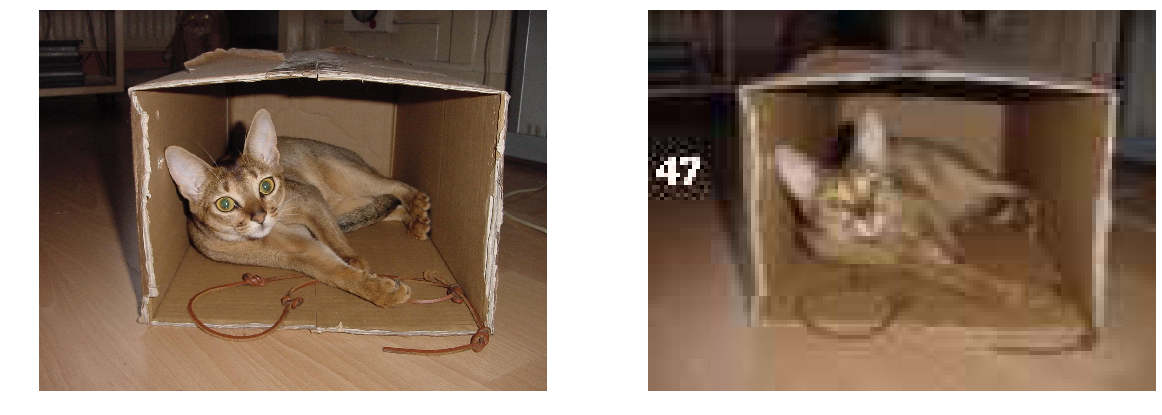

In [7]:
img=10

axs = subplots(1, 2,figsize=(20,20)).flatten()
open_image(path_hr.ls()[img]).show(ax=axs[0])
open_image(path_lr.ls()[img]).show(ax=axs[1])

In [8]:
bs,size=32, 128
arch = models.resnet34

## Pre-Train Generator
Here we will start by using a pretrained model for the Generator. The reasoning here is simply that in order to perform the task of increasing resolution or removing watermarks, the model should know what is meant to be there. Therefore, it makes sense to use a model that is already familiar with these original images. Here we will be using a resnet34 architecture.

In [9]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [10]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [11]:
data_gen = get_data(bs,size)

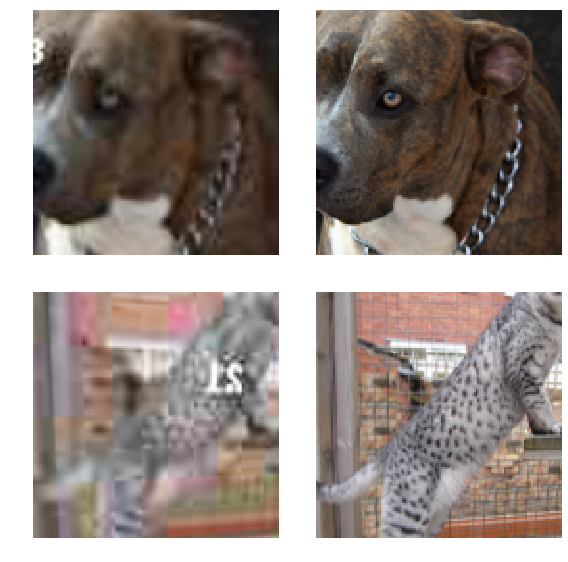

In [12]:
data_gen.show_batch(2)

In [13]:
wd = 1e-3
y_range = (-3.,3.)

`MSELossFlat` is based on the pytorch nn.MSELoss() class, except with the added flatten function. This is because `MSELoss` expects 2 vectors but we have 2 images, therefore we flatten the images into vectors for pixel comparison.

In [ ]:
loss_gen = MSELossFlat()

## U-Net Learner Object
Used in segmentation, this underlying model is a DynamicUnet with blur, blur_final, self_attention, sigmoid and last_cross. 

In [14]:
# The Generator Model
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [15]:
learn_gen = create_gen_learner()

In [16]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss
1,0.066877,0.055922
2,0.052279,0.049630


Note: when creating a U-Net model, by default in fastai and transfer learning, the pre-trained part is frozen. In a U-Net, this refers to the downsampling portion of the architeture. Therefore, lets unfreeze this now.

In [17]:
learn_gen.unfreeze()

In [18]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,0.050359,0.047938
2,0.048829,0.046142
3,0.047185,0.044574


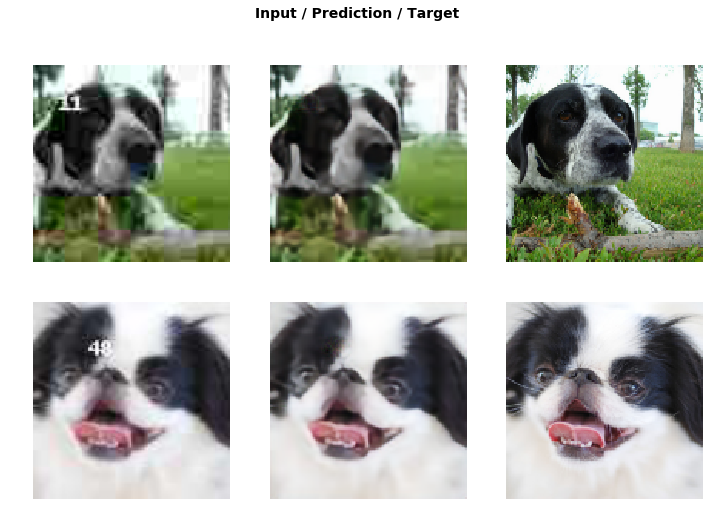

In [ ]:
learn_gen.show_results(rows=2)

In [ ]:
learn_gen.save('gen-pre2')

Immediately, the results are pretty good. The model has done a great job of removing the numbers drawn over. However, the resolution could be better and certain features could be further refined such as acknowledging fur textures and refining eyeballs etc.<br><br>
Whilst the model is now good at making predictions/generating decent iamges, we now want to build another model that will critique this generated image. This notion is explored through Generative adversarial networks (GANs).
Previously, we had a MSELoss function that compared pixels between a real image and a fake image. But now we want a more complex loss function i.e. is this generated image a "good" image?<br><br>
GAN solves this by using a loss function, which calls another model to decide "Is this a high res image or a fake image". This is a simple binary classification problem and therefore the loss function will be CrossEntropyLoss for this `critic` model.<br>
The idea is then to train the critic to be really good at identifying fake images. Then the new loss function is really "can we fool the critic", which implies that the generator model is building images that are so good that they fool the critic.<br><br>
NOTE: The overall process is to train the critic then train the generator and back and forth. 
![gan_schema](./images/gan_schema.png)
_fastai Lesson 7_

## Build A Critic Model
The critic model will try to predict if an image is real or generated. Therefore, we require a folder of real images and a folder of generated images. So here we will save the generated images first:

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
path_gen.mkdir(exist_ok=True)

In [ ]:
def save_preds(dl):
    i=0
    
    # The items in an image_clas dataset is the list of filenames
    names = dl.dataset.items
    
    # Grab a batch of predictions in the dataloader
    for b in dl:
        
        # reconstruct = True: create fastai image objects
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            # save all the predictions
            o.save(path_gen/names[i].name)
            i += 1

In [ ]:
save_preds(data_gen.fix_dl)

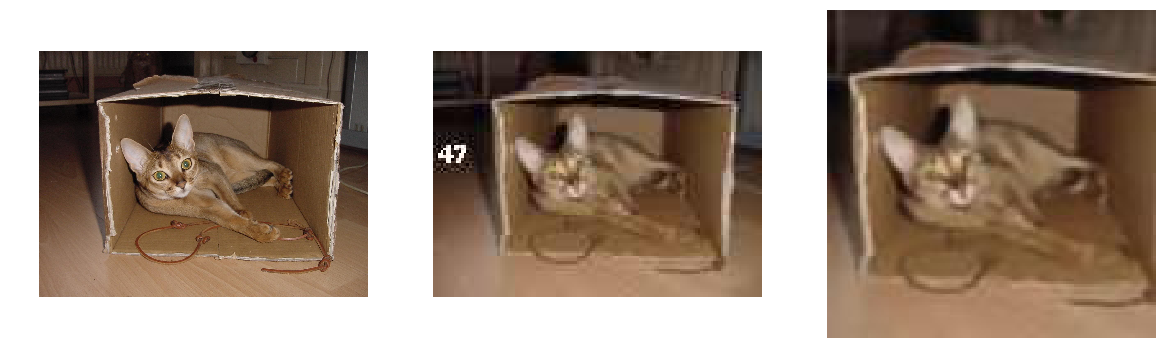

In [ ]:
img=10

axs = subplots(1, 3,figsize=(20,20)).flatten()
open_image(path_hr.ls()[img]).show(ax=axs[0])
open_image(path_lr.ls()[img]).show(ax=axs[1])
open_image(path_gen.ls()[img]).show(ax=axs[2])

## Train the Critic

In [ ]:
learn_gen=None
# garbage collection on GPU
gc.collect()

13

In [ ]:
# Basic object classifier
def get_crit_data(classes, bs, size):
    src = ImageItemList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [ ]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

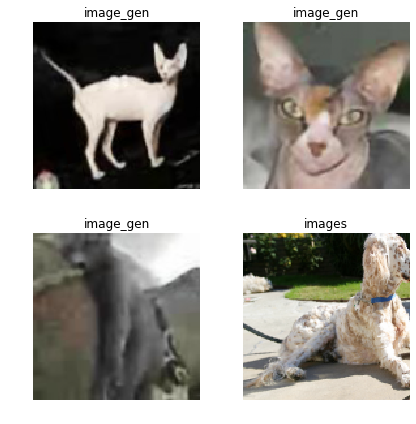

In [ ]:
data_crit.show_batch(rows=2, ds_type=DatasetType.Train, imgsize=3)

Gan critic uses a different way of averaging different parts of image when it calculates the loss. So here we will wrap the loss function in AdaptiveLoss.<br><br>
Applying AdaptiveLoss to the Pytorch BCEWithLogitsLoss function, will expand the `target` to match the `output` size before applying `crit`.

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

NOTE: The critic here wont be a resnet model (similar to the generator model). The reason for this is that we don't want the generator and the critic to be influencing weights in the same way (and ultimately leading them to excessively large weights).<br><br>However, a pretrained resnet with spectral_norm may also suffice. Here we will use a `gan_critic()`, which incorporates spectral normalization and produces an appropriate binary classifier.
- `data_crit` is the data object associated with the critic dataset
- `accuracy_thresh_expand` is the accuracy measure after expanding `y_true` to the size of `y_pred`

In [ ]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand
1,0.691696,0.688351,0.559373
2,0.332111,0.301840,0.877835
3,0.163448,0.263933,0.902222
4,0.090334,0.160950,0.943760
5,0.071413,0.043183,0.990513
6,0.051683,0.061225,0.984416


In [ ]:
learn_critic.save('critic-pre2')

## Combining Pre-Trained Model Into GAN

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

7132

In [ ]:
data_crit = get_crit_data(['low_res', 'images'], bs=bs, size=size)
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')
learn_gen = create_gen_learner().load('gen-pre2')

NOTE: A GAN Learner requires specific learner objects i.e. the generator model and the critic model. The optimization will switch between both models and be applied separately. To faciliate this, we use the helpful callback options to define when to switch from the generator to critic i.e. the switcher callback. In this application, we will keep iterating over the critic until the loss has reduced once again to less than 0.5. Using the critic loss function, `learn_crit.loss_func`, we take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predictions (target 0). 

Once this is complete, one iteration is applied to the generator. The generator loss is weighted sum of the critics loss function on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the generators loss function applied to the output (batch of fake) and the target (corresponding batch of superres images). 

- `weights_gen`: contains the weights for `learn_crit.loss_func` and `learn_gen.loss_func` objects. Since the losses for the Generator and Critic are on different scales, we multiply the critic loss by approximately 50~200 to improve performance.
- `betas`: coefficients used for computing running averages of gradient (momentum) and its square (default: (0.9, 0.999)). However, at this time it appears momentum doesn't work well with GANs and moreover, since we are switching the loss function between the Generator and Critic, it doens't make sense to use any momentum. Therefore, we set the momentum to 0.

In [ ]:
# Using the partial function, we can implemented the Switcher Callback
# which goes back to generator/critic when the loss goes below `gen_thresh`/`crit_thresh`
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)


learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, 
                                 switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)

# GANDiscriminativeLR callback handles multiplying the LR by `mult_lr` for the critic.
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
learn.fit(40,1e-4)

epoch,train_loss,gen_loss,disc_loss
1,1.942280,0.719899,3.913753
2,2.022089,2.175992,3.664762
3,2.093734,0.767089,3.654508
4,2.024233,1.878506,3.628411
5,2.000147,1.990890,3.624588
6,1.975902,1.965656,3.607044
7,1.988532,1.503813,3.601728
8,2.084328,1.723404,3.672016
9,2.106955,1.053491,3.653295
10,1.996047,1.891081,3.645523


NOTE: These losses above are meaningless as the critic and generator learner objects are constantly being refined to better challenge eachother. That is, the generator is trained to be great at generating realistic images and then the critic is trained to become better at criticizing images, which in turn challenges the generator to become better at generating images and so on.

In [ ]:
learn.save('gan-1c')

In [47]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,5e-5)

epoch,train_loss,gen_loss,disc_loss
1,2.568647,2.485472,4.730136
2,2.513052,2.431982,4.666157
3,2.524599,2.617515,4.744229


In [52]:
learn.save('gan-1c')

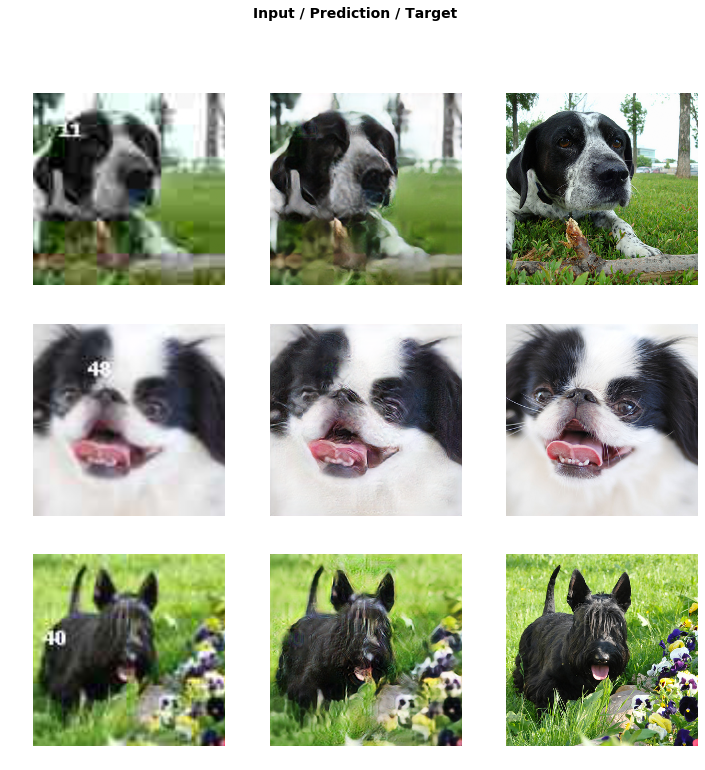

In [54]:
learn.show_results(rows=3)

## Results
As seen above, the images generator from the above model is quite impressive albeit not perfect. After reviewing the predicted images, it can be seen that the Generator still doesn't appreciate the finer textures, such as grass and fur etc. This is likely to stem from the fact that the Critic itself was not pretrained on images and therefore is not great at critiquing these finer textures (and not challenging the Generator do so a better job in these more detailed areas). 

## Suggested Improvements For Part II
So can we come up with a better loss function i.e. not just high quality but a deeper appreciation for if the generated image actually looks like how you would expect. Can we remove GANs entirely???

[Continue to Part II](https://github.com/danieldiamond/dl-projects/blob/master/super-resolution/part-ii-super-res-using-feature-loss.ipynb)